<a href="https://colab.research.google.com/github/devhemza/deeplearningproject/blob/main/Attempt_from_scratch_Keras_abstractive_text_summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Since the GRUs are bi-directional, there is both a forward and a backward state which are combined (concatenated) as the encoder state.

In [ ]:
!pip install pyrouge

     |████████████████████████████████| 61kB 3.2MB/s 
  Created wheel for pyrouge: filename=pyrouge-0.1.3-cp36-none-any.whl size=191613 sha256=e3b668abf52e62f187c3c8a33a79360063bf018cbc9f4d2f4ea465a75c6bae6c
  Stored in directory: /root/.cache/pip/wheels/75/d3/0c/e5b04e15b6b87c42e980de3931d2686e14d36e045058983599
Successfully built pyrouge


In [ ]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [ ]:
from numpy.random import seed
seed(1)

from sklearn.model_selection import train_test_split as tts
import logging
import tensorflow as tf

from pyrouge import Rouge155 
import matplotlib.pyplot as plt
import keras
from keras import initializers
from keras.optimizers import RMSprop, Adadelta
from keras.models import Model
from keras.layers import Bidirectional, Dense,GRU,Input,Activation,Add,TimeDistributed,\
Permute,Flatten,RepeatVector,merge,Lambda,Multiply,Reshape, Attention, Embedding, Concatenate
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

Load data 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/M2/DeepLearning/DeepProject/text-summarization-tensorflow-master"

/content/drive/MyDrive/M2/DeepLearning/DeepProject/text-summarization-tensorflow-master


In [ ]:
!pip install gensim
!pip install wget
  
import nltk
nltk.download('punkt')

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=c9a28a412466905495db2edd3b379ab0a7270cdfb5778f5880a0835e174a1b46
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from nltk.tokenize import word_tokenize
import re
import collections
import pickle
import numpy as np
from gensim.models.keyedvectors import KeyedVectors
from gensim.test.utils import get_tmpfile
from gensim.scripts.glove2word2vec import glove2word2vec

default_path = "./sample_data/"

train_article_path = default_path + "sumdata/train/train.article.txt"
train_title_path   = default_path + "sumdata/train/train.title.txt"
valid_article_path = default_path + "sumdata/train/valid.article.filter.txt"
valid_title_path   = default_path + "sumdata/train/valid.title.filter.txt"

#valid_article_path = default_path + "sumdata/DUC2003/input.txt"
#valid_title_path   = default_path + "sumdata/DUC2003/task1_ref0.txt"

def clean_str(sentence):
    sentence = re.sub("[#.]+", "#", sentence)
    return sentence


def get_text_list(data_path, toy):
    with open (data_path, "r", encoding="utf-8") as f:
        if not toy:
            return [clean_str(x.strip()) for x in f.readlines()][:200000]
        else:
            return [clean_str(x.strip()) for x in f.readlines()][:50]

  
def build_dict(step, toy=False):
    if step == "train":
        train_article_list = get_text_list(train_article_path, toy)
        train_title_list = get_text_list(train_title_path, toy)

        words = list()
        for sentence in train_article_list + train_title_list:
            for word in word_tokenize(sentence):
                words.append(word)

        word_counter = collections.Counter(words).most_common()
        word_dict = dict()
        word_dict["<padding>"] = 0
        word_dict["<unk>"] = 1
        word_dict["<s>"] = 2
        word_dict["</s>"] = 3
        for word, _ in word_counter:
            word_dict[word] = len(word_dict)

        with open(default_path + "word_dict.pickle", "wb") as f:
            pickle.dump(word_dict, f)

    elif step == "valid":
        with open(default_path + "word_dict.pickle", "rb") as f:
            word_dict = pickle.load(f)

    reversed_dict = dict(zip(word_dict.values(), word_dict.keys()))

    article_max_len = 50
    summary_max_len = 50

    return word_dict, reversed_dict, article_max_len, summary_max_len


def build_dataset(step, word_dict, article_max_len, summary_max_len, toy=False):
    if step == "train":
        article_list = get_text_list(train_article_path, toy)
        title_list = get_text_list(train_title_path, toy)
    elif step == "valid":
        article_list = get_text_list(valid_article_path, toy)
    else:
        raise NotImplementedError

    x = [word_tokenize(d) for d in article_list]
    x = [[word_dict.get(w, word_dict["<unk>"]) for w in d] for d in x]
    x = [d[:article_max_len] for d in x]
    x = [d + (article_max_len - len(d)) * [word_dict["<padding>"]] for d in x]
    
    if step == "valid":
        return x
    else:        
        y = [word_tokenize(d) for d in title_list]
        y = [[word_dict.get(w, word_dict["<unk>"]) for w in d] for d in y]
        y = [d[:(summary_max_len - 1)] for d in y]
        y = [d + (summary_max_len - len(d)) * [word_dict["<padding>"]] for d in y]
        return x, y


def get_init_embedding(word_dict , reversed_dict, embedding_size):
    embedding_matrix = np.zeros((len(word_dict) + 1, embedding_size))
    print("Loading Lists...")
    train_article_list = get_text_list(train_article_path, False)
    train_title_list = get_text_list(train_title_path, False)

    print("Loading TF-IDF...")
    tf_idf_list = tf_idf_generate(train_article_list+train_title_list)
    
    print("Loading Pos Tags...")
    pos_list , postags_for_named_entity = get_pos_tags_dict(word_dict.keys())

    print("Loading Named Entity...")
    named_entity_recs = named_entity(postags_for_named_entity) 
    
    print("Loading Glove vectors...")

    with open( default_path + "model_glove_300.pkl", 'rb') as handle:
        word_vectors = pickle.load(handle)
     
    
    used_words = 0
    word_vec_list = list()
    for i, word in sorted(reversed_dict.items()):
        try:
            word_vec = word_vectors.word_vec(word)
            if word in tf_idf_list:
              v= tf_idf_list[word]
              rich_feature_array = np.array([v,v,v,v,v,v,v,v,v,v])
              word_vec = np.append(word_vec, rich_feature_array)
            else:
              v=0
              rich_feature_array = np.array([v,v,v,v,v,v,v,v,v,v])
              word_vec = np.append(word_vec, rich_feature_array)

            if word in pos_list:
              v=pos_list[word]
              rich_feature_array_2 = np.array([v,v,v,v,v,v,v,v,v,v])
              word_vec = np.append(word_vec, rich_feature_array_2)
            else:
              v=0
              rich_feature_array_2 = np.array([v,v,v,v,v,v,v,v,v,v])
              word_vec = np.append(word_vec, rich_feature_array_2) 

            if word in named_entity_recs:
              v=named_entity_recs[word]
              rich_feature_array_3 = np.array([v,v,v,v,v,v,v,v,v,v])
              word_vec = np.append(word_vec, rich_feature_array_3)
            else:
              v=0
              rich_feature_array_3 = np.array([v,v,v,v,v,v,v,v,v,v])
              word_vec = np.append(word_vec, rich_feature_array_3)  
          
            used_words += 1
        except KeyError:
            word_vec = np.zeros([embedding_size], dtype=np.float32) #to generate for <padding> and <unk>
        
        
        word_vec_list.append(np.array(word_vec))
        embedding_matrix[i] = word_vec

    print("words found in glove percentage = " + str((used_words/len(word_vec_list))*100) )
          
    # Assign random vector to <s>, </s> token
    word_vec_list[2] = np.random.normal(0, 1, embedding_size)
    word_vec_list[3] = np.random.normal(0, 1, embedding_size)
     
    return embedding_matrix

#### TF-IDF

In [ ]:
# _____TF-IDF libraries_____
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# _____helper Libraries_____
import pickle  # would be used for saving temp files
import csv     # used for accessing the dataset
import timeit  # to measure time of training
import random  # used to get a random number


def tf_idf_generate(sentences):
    #https://stackoverflow.com/questions/30976120/find-the-tf-idf-score-of-specific-words-in-documents-using-sklearn

    from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
    # our corpus
    data = sentences

    cv = CountVectorizer()

    # convert text data into term-frequency matrix
    data = cv.fit_transform(data)

    tfidf_transformer = TfidfTransformer()

    # convert term-frequency matrix into tf-idf
    tfidf_matrix = tfidf_transformer.fit_transform(data)

    # create dictionary to find a tfidf word each word
    word2tfidf = dict(zip(cv.get_feature_names(), tfidf_transformer.idf_))

    #i = 0
    #for word, score in word2tfidf.items():
    #    print(word, score)
    #    if (i == 10):
    #      break
    #    i+=1  
  
    return word2tfidf

### POS tags

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
#https://stackoverflow.com/questions/38088652/pandas-convert-categories-to-numbers
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag

#ex = 'European authorities fined Google a record $5.1 billion on Wednesday for abusing its power in the mobile phone market and ordered the company to alter its practices'

def get_pos_tags_dict(words):
    #sent = nltk.word_tokenize(sent)
    #print(sent)
    post_tags_for_words = nltk.pos_tag(words)

    pos_list ={}
    #sent = preprocess(ex)
    for word,pos in post_tags_for_words:
        pos_list[word] = pos
    #print(pos_list)

    import pandas as pd
    df = pd.DataFrame(list(pos_list.items()))
    df.columns = ['word', 'pos']
    df.pos = pd.Categorical(df.pos)
    df['code'] = df.pos.cat.codes
    #print(df)

    pos_list ={}
    for index, row in df.iterrows():
       pos_list[row['word']] = row['code']
    print(pos_list)
    return pos_list , post_tags_for_words

### Named Entity Reognition

In [ ]:
import nltk
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [ ]:
#https://nlpforhackers.io/named-entity-extraction/
from nltk import word_tokenize, pos_tag, ne_chunk

#sentence = "Mark and John are working at Google."


#print (ne_chunk(pos_tag(word_dict.keys())[:5]))
#names = ne_chunk(pos_tag(word_tokenize(sentence)))

#names = ne_chunk(pos_tag(word_tokenize(sentence)))

def named_entity(post_tags_for_words):
  names = ne_chunk(post_tags_for_words)
  names_dict = {}
  for n in names:
    if (len(n) == 1):
      named_entity = str(n).split(' ')[0][1:]
      word = str(n).split(' ')[1].split('/')[0]
      names_dict[word] = named_entity
  print (names_dict)

  import pandas as pd
  df = pd.DataFrame(list(names_dict.items()))
  df.columns = ['word', 'pos']
  df.pos = pd.Categorical(df.pos)
  df['code'] = df.pos.cat.codes
  #print(df)

  names_dict ={}
  for index, row in df.iterrows():
     names_dict[row['word']] = row['code']
  print(names_dict)
  return names_dict

In [ ]:
!ls sample_data

Glove		     result_featurerich_15_11_2018_5_28pm.xml  word_dict.pickle
model_glove_300.pkl  saved_model_2
result2.txt	     sumdata


In [ ]:
print("Building dictionary...")
word_dict, reversed_dict, article_max_len, summary_max_len = build_dict("train", False)
print("Loading training dataset...")
train_x, train_y = build_dataset("train", word_dict, article_max_len, summary_max_len, False)

Building dictionary...
Loading training dataset...


In [ ]:
train_embedding = get_init_embedding(word_dict , reversed_dict, 330)


In [ ]:
train_embedding.shape

(17213, 330)

In [ ]:
train_embedding[1].shape

(330,)

In [ ]:
train_embedding.shape

(17213, 330)

In [ ]:
np.shape(train_x[1])

(50,)

In [ ]:
def embedding_matrix_creater(embedding_dim, word_index):
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
          # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

Model

In [ ]:
### Constructor for baseline enc. dec. network.
### Adding the encoder
#######################model params###########################
batch_size = 50
num_classes = 1
epochs = 20
learning_rate = 0.005
clip_norm = 2.0
en_shape = np.shape(train_x)
de_shape = np.shape(train_y[1])
hidden_units = 400
###############################################################
###############################################################

encoder_inputs = Input(shape = (en_shape[1], ))
print(encoder_inputs)

"""_______encoder________"""

# GRU
encoder_embedding_layer = Embedding(train_embedding.shape[0], 330, input_length = 50,  weights = [train_embedding])
encoder_embedding = encoder_embedding_layer(encoder_inputs)
encoder_GRU = Bidirectional(GRU(hidden_units, return_sequences=True, return_state=True))
encoder_output, encoder_fs, encoder_bs = encoder_GRU(encoder_embedding)

encoder_state = Concatenate()([encoder_fs, encoder_bs])

Tensor("input_4:0", shape=(None, 50), dtype=float32)


In [ ]:
encoder_embedding.shape

TensorShape([None, 50, 330])

In [ ]:
### Adding the decoder
decoder_input = Input(shape=(None, ))
decoder_embedding = Embedding(train_embedding.shape[0], train_embedding.shape[1], input_length = 50,  weights = [train_embedding])(decoder_input)

# GRU using encoder_states as initial state
decoder_gru = GRU(hidden_units*2, return_sequences=True, return_state=True)
decoder_output, decoder_state = decoder_gru(decoder_embedding, initial_state=[encoder_state])

In [ ]:
# Attention Layer for alignment model and computation of weights for all encoder hidden states
attention_layer = AttentionLayer() 
attention_out, attention_states = attention_layer([encoder_output, decoder_output])

# Concat attention output and decoder GRU output
decoder_concatenate = Concatenate(axis=-1)([decoder_output, attention_out])

# Dense layer for generating words from vocabulary distribution
decoder_dense = TimeDistributed(Dense(train_embedding.shape[0]+1, activation='softmax'))
decoder_dense_output = decoder_dense(decoder_concatenate)

# Define the model
model = Model(inputs = [encoder_inputs, decoder_input], outputs = decoder_dense_output)
opt = Adadelta()
model.compile(optimizer=opt, loss='categorical_crossentropy')

In [ ]:
model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 330)      5680290     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 50, 800), (N 1756800     embedding[0][0]                  
_______________________________________________________________________________________

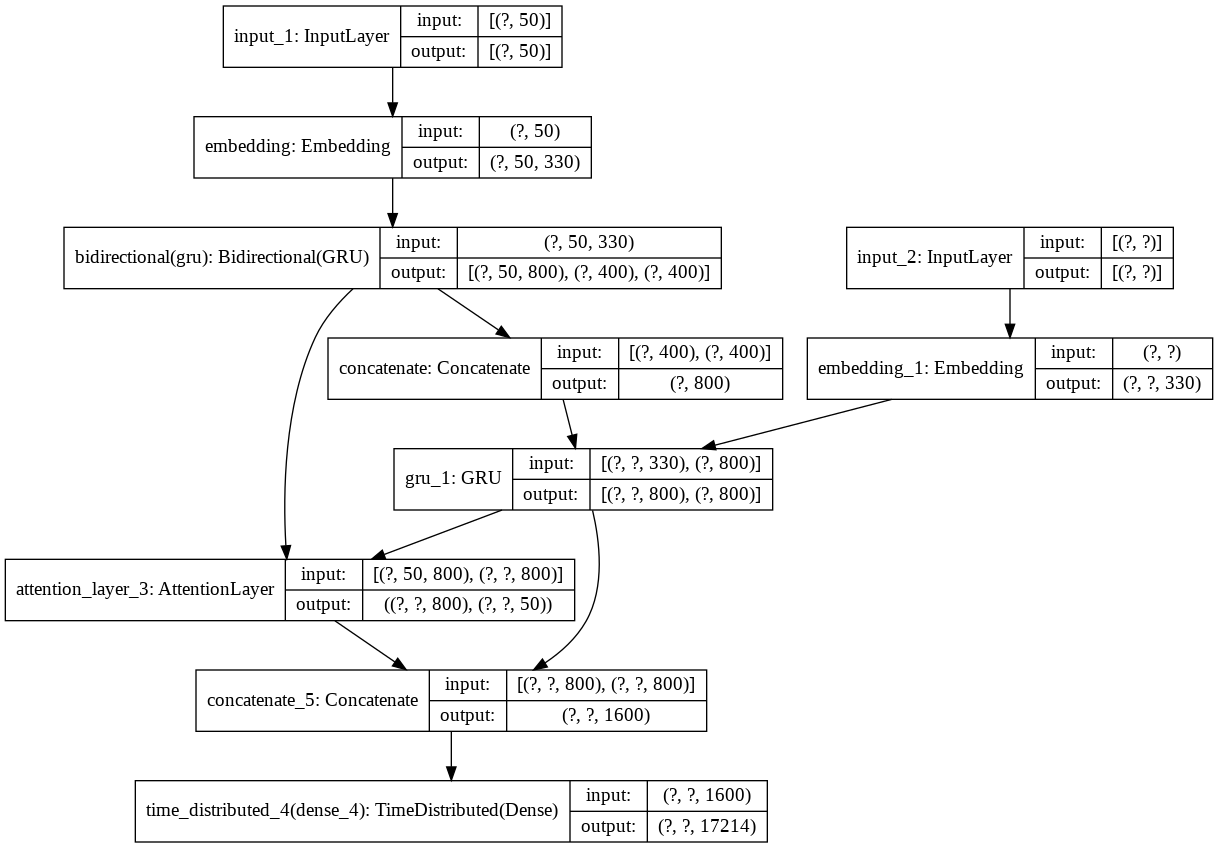

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
train_X = tf.convert_to_tensor(train_x)
train_Y = tf.convert_to_tensor(train_y)

In [ ]:
model.fit([train_X, train_Y], train_Y)

ValueError: ignored